In [32]:
import numpy as np
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import math
import random

import geopandas as gpd
import pandas as pd

import itertools
from collections import Counter

from ast import literal_eval

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm as cm

from scipy.stats import zscore

import folium
import branca.colormap as cmp
import json

from gensim import corpora

from gensim.models.coherencemodel import CoherenceModel

In [54]:
logger = logging.getLogger()
logger.setLevel(level=logging.INFO)

NameError: name 'logging' is not defined

---

---

In [33]:
## code from https://github.com/qiangsiwei/shanghai_geographical_topics

# list of documents -> docs
# for doc in docs: doc[0] -> locality + doc[1] -> content as a list of words

In [34]:
class LDALocalGlobalSampler(object):
    def __init__(self, docs=None, conts=None, num_topics=None, alpha=0.5, beta=0.5, gama=0.2, lamd=1.0):
        self.a, self.b, self.c, self.d, self.T = float(alpha), float(beta), float(gama), float(lamd), int(num_topics)
        self.docs, self.conts = docs, conts
        self.locs = list(set(doc[0] for doc in self.docs))
        self.vocab = list(set(word for doc in self.docs for word in doc[1]))
        self.L, self.W = len(self.locs), len(self.vocab)
        self.to_id = {loc: i for (i, loc) in enumerate(self.locs)}
        self.to_int = {word: w for (w, word) in enumerate(self.vocab)}
        self.nt = [0] * self.T
        self.ndc = [[0] * 2 for _ in self.docs]
        self.ng, self.nl = 0, [0 for _ in self.locs]
        self.ngt, self.nlt = [0] * self.T, [[0] * self.T for _ in self.locs]
        self.nwt = [[0] * self.T for _ in self.vocab]
        self.assignments = []
        for _d, (_loc, _doc) in enumerate(self.docs):
            for _i, _word in enumerate(_doc):
                _l = self.to_id[_loc]
                _w = self.to_int[_word]
                _c = int(random.randint(0, max(1,self.d)) >= 1)
                _t = random.randint(0, self.T-1)
                _z = [_d, _l, _w, _c, _t]
                self.assignments.append(_z)
        for _z in self.assignments:
            _d, _l, _w, _c, _t = _z
            self.ndc[_d][_c] += 1
            if _c:
                self.nl[_l] += 1
                self.nlt[_l][_t] += 1
            else:
                self.ng += 1
                self.ngt[_t] += 1
            self.nt[_t] += 1
            self.nwt[_w][_t] += 1

    def next(self):
        return math.exp(-sum([self.sample(z) for z in self.assignments])/sum(self.nt))

    def sample(self, z):
        _d, _l, _w, _c_old, _t_old = z
        # restore
        self.ndc[_d][_c_old] -= 1
        if _c_old:
            self.nl[_l] -= 1
            self.nlt[_l][_t_old] -= 1
        else:
            self.ng -= 1
            self.ngt[_t_old] -= 1
        self.nt[_t_old] -= 1
        self.nwt[_w][_t_old] -= 1
        # sample
        unnorm_ps = [(0, t, self.h1(_w,t)*self.f(_d,0)) for t in range(self.T)] + \
                    [(1, t, self.h2(_l,_w,t)*self.f(_d,1)*self.d) for t in range(self.T)]
        r = random.random() * sum([_p[2] for _p in unnorm_ps])
        _c_new, _t_new = 1, self.T-1
        for i in range(2*self.T):
            r = r - unnorm_ps[i][2]
            if r < 0:
                _c_new, _t_new, _ = unnorm_ps[i]
                break
        # compute log properbility
        _properbility = math.log(self.h2(_l,_w,_t_new) if _c_new else self.h1(_w,_t_new))
        # update
        z[3], z[4] = _c_new, _t_new
        self.ndc[_d][_c_new] += 1
        if _c_new:
            self.nl[_l] += 1
            self.nlt[_l][_t_new] += 1
        else:
            self.ng += 1
            self.ngt[_t_new] += 1
        self.nt[_t_new] += 1
        self.nwt[_w][_t_new] += 1
        return _properbility

    def f(self, d, c): # sample for locality
        return self.ndc[d][c] + self.c

    def h1(self, w, t): # sample for global topic
        return (self.ngt[t] + self.a) / (self.ng + self.a * self.T) * \
               (self.nwt[w][t] + self.b) / (self.nt[t] + self.b * self.W)

    def h2(self, l, w, t): # sample for local topic
        return (self.nlt[l][t] + self.a) / (self.nl[l] + self.a * self.T) * \
               (self.nwt[w][t] + self.b) / (self.nt[t] + self.b * self.W)

    def pw_z(self, w, t):
        return (self.nwt[w][t] + self.b) / (self.nt[t] + self.b * self.W)

    def estimate_phi(self):
        return [[self.pw_z(w, t) for w in range(self.W)] for t in range(self.T)]

    def pz_d(self, l, t):
        return (self.nlt[l][t] + self.a) / (self.nl[l] + self.a * self.T)

    def estimate_theta(self):
        return [[self.pz_d(l, t) for t in range(self.T)] for l in range(self.L)]

    def topic_weight(self, t):
        return self.nt[t]
        
    def topic_keys(self, return_prob=False, num_displayed=10):
        phi, tks = self.estimate_phi(), []
        for w_ps in phi:
            if return_prob:
                tks.append([p for p in w_ps])
            else:
                tuples = [(p, self.vocab[i]) for i, p in enumerate(w_ps)]
                tuples.sort(reverse=True)
                tks.append([word for (p, word) in tuples[:num_displayed]])
        return tks

    def local_topics(self):
        theta, dks = self.estimate_theta(), []
        for t_ps in theta:
            tuples = [(p, t) for t, p in enumerate(t_ps)]
            tuples.sort(reverse=True)
            dks.append(tuples)
        return dks

    def global_topics(self):
        tuples = [(p, t) for t, p in enumerate([
            (self.ngt[t] + self.a) / (sum(self.ngt) + self.a * self.T)
                for t in range(self.T)])]
        tuples.sort(reverse=True)
        return tuples

    def doc_locality(self, ratio, locations=[]):
        _dict = {}
        for z in self.assignments:
            _d, _l, _w, _c, _t = z
            _dict[_d] = _dict.get(_d,{'len':0,'glob':0,'local':0})
            _dict[_d]['len'] += 1
            _dict[_d]['glob'] += self.h1(_w,_t)
            _dict[_d]['local'] += self.h2(_l,_w,_t)
        _tuples = [(_v['local']/_v['len'],[_v['local']/_v['glob'], _d]) for _d, _v in _dict.items()]
        _tuples.sort(reverse=True)
        for _index in xrange(int(len(_tuples)*ratio), int(len(_tuples)*ratio)+10**4):
            if self.conts[_tuples[_index][1][1]][0] in locations:
                print(_tuples[_index], '\t'.join(self.conts[_tuples[_index][1][1]]))

In [35]:
#LDALocalGlobalSampler(docs=_docs, conts=_conts, num_topics=num_topics, alpha=0.5, beta=0.5, gama=0.5, lamd=local_radio)

In [36]:
def run_tfidf(num_clusters=20, num_displayed=10, print_results=False):
    _index, _docs, _freqs, _dicts = 0, [], {}, {}
    for _name, _list in _location_dict.items():
        if len(_list) >= LOCATION_THRES:
            _list = [_entry['_words'] for _entry in sorted(_list, 
                        key=lambda _en:_en['_len'], reverse=True)[:REVIEW_LIMIT]]
            for _doc in _list:
                _docs.append(' '.join(_doc))
                _freqs[_name] = _freqs.get(_name,{})
                _dicts[_name] = _dicts.get(_name,[]) + [_index]
                for _word in _doc:
                    #_word = _word.decode('utf-8')
                    _freqs[_name][_word] = _freqs[_name].get(_word,0)+1
                _index += 1
    if print_results: print(len(_dicts))
    transformer, vectorizer = TfidfTransformer(), CountVectorizer()
    tfidf = transformer.fit_transform(vectorizer.fit_transform(_docs))
    _words, _weights = vectorizer.get_feature_names(), tfidf.toarray()
    if print_results: print('word vector length:', len(_weights))
    word_vector = []
    for _i, (_name, _list) in enumerate(_dicts.items()):
        _weight = np.array([_weights[_ele] for _ele in _list]).sum(axis=0)
        word_vector.append(_weight)
        _keywords = [u'{},{}'.format(_item['_word'],_freqs[_name].get(_item['_word'],0))
                        for _item in sorted([{'_word':_word,'_value':_value} 
                                                for (_word,_value) in zip(_words,_weight)], 
                                            key=lambda _entry:_entry['_value'], reverse=True)]
        # show location keywords
        if print_results: print(_i, _name, '\t'.join(_keywords[:num_displayed]))
    from sklearn.cluster import KMeans
    est = KMeans(n_clusters=num_clusters)
    est.fit(word_vector)
    for _cluster_center in est.cluster_centers_:
        _tuples = [(_value, _word) for _word, _value in enumerate(_cluster_center)]
        _tuples.sort(reverse=True)
        # show cluster keywords
        if print_results: print('\t'.join([_words[_word] for (_value, _word) in _tuples[:num_displayed]]))

In [37]:
def run_lda(model, num_iteration=101, save_step=20, num_topics=20, local_radio=0.6):
    _index, _docs, _conts = 0, [], []
    for _name, _list in _location_dict.items():
        if len(_list) >= LOCATION_THRES:
            _list = [(_entry['_words'],_entry['_cont']) for _entry in 
                        sorted(_list, key=lambda _en:_en['_len'], reverse=True)[:REVIEW_LIMIT]]
            # print _index, _name, len(_list)
            _docs.extend([(_name,_doc[0]) for _doc in _list])
            _conts.extend([(_name,_doc[1]) for _doc in _list])
            _index += 1
    if model == 'LDASampler':
        lda = LDASampler(docs=_docs, num_topics=num_topics, alpha=0.5, beta=0.5)
    if model == 'LDALocalSampler':
        lda = LDALocalSampler(docs=_docs, num_topics=num_topics, alpha=0.5, beta=0.5)
    if model == 'LDALocalGlobalSampler':
        lda = LDALocalGlobalSampler(docs=_docs, conts=_conts, num_topics=num_topics, alpha=0.5, beta=0.5, gama=0.5, lamd=local_radio)
    for _index in range(num_iteration):
        print("iteration:", _index)
        perplexity = lda.next()
        if _index % save_step == 0:
            path_file = 'lgda_results/iteration_{}.txt'.format(str(_index).zfill(3))
            with open(path_file,'w') as _file:
                print("perplexity:", perplexity)
                # save word topic probabilities
                _file.write('word topic probabilities:\n')
                tks = lda.topic_keys()
                for i, tk in enumerate(tks):
                    _file.write('{}\t{}\t{}\n'.format(i, lda.topic_weight(i), '\t'.join(tk)))
                # save local topic probabilities
                _file.write('local topic probabilities:\n')
                dks, entropy = lda.local_topics(), {'topic':0,'probs':{}}
                for l, dk in enumerate(dks):
                    _file.write('{}\n{}\n'.format(lda.locs[l], '\t'.join(['{}:{:.3}'.format(t, p) for (p, t) in dk])))
                    entropy['topic'] += -sum([p*math.log(p) for (p, t) in dk])
                    for (p, t) in dk:
                         entropy['probs'][t] = entropy['probs'].get(t,[])+[p]
                tks, KL = lda.topic_keys(return_prob=True), 0
                for _i, _prob1 in enumerate(tks):
                    for _j, _prob2 in enumerate(tks):
                        if _i != _j:
                            KL += -sum([_p1*math.log(_prob2[_k]/_p1) for _k, _p1 in enumerate(_prob1)])
                print("topic entropy:", entropy['topic']/len(dks))
                print("location entropy:", sum([sum([-p*math.log(p) for p in ps]) for t, ps in entropy['probs'].items()])/len(entropy['probs']))
                print("topic KL-divergence:", KL/(len(tks)*(len(tks)-1)))
                # save global topic probabilities
                # if model == 'LDALocalGlobalSampler':
                #     _file.write('global topic probabilities:\n')
                #     _file.write('{}\n'.format('\t'.join(['{}:{:.3}'.format(t, p) for (p, t) in lda.global_topics()])))
                #     lda.doc_locality(ratio=0, locations=["外滩"])


In [38]:
def run_lda_assess(model
                  , num_iteration=101
                  , save_step=20
                  , num_topics=20
                  , local_radio=0.6
                  , alpha=0.5
                  , beta=0.5
                  , gamma=0.5
                  , r_seed = 0
                  , print_steps = False
                  , write_results = False
                  , corpus = None
                  ,dictionary = None
                 ):
    
    _index, _docs, _conts = 0, [], []
    for _name, _list in _location_dict.items():
        if len(_list) >= LOCATION_THRES:
            _list = [(_entry['_words'],_entry['_cont']) for _entry in 
                        sorted(_list, key=lambda _en:_en['_len'], reverse=True)[:REVIEW_LIMIT]]
            # print _index, _name, len(_list)
            _docs.extend([(_name,_doc[0]) for _doc in _list])
            _conts.extend([(_name,_doc[1]) for _doc in _list])
            _index += 1
    if model == 'LDASampler':
        lda = LDASampler(docs=_docs, num_topics=num_topics, alpha=0.5, beta=0.5)
    if model == 'LDALocalSampler':
        lda = LDALocalSampler(docs=_docs, num_topics=num_topics, alpha=0.5, beta=0.5)
    if model == 'LDALocalGlobalSampler':
        random.seed(r_seed)
        lda = LDALocalGlobalSampler(docs=_docs
                                    , conts=_conts
                                    , num_topics=num_topics
                                    , alpha=alpha
                                    , beta=beta
                                    , gama=gamma
                                    , lamd=local_radio#0.6 ###### TODO #######
                                   )
    
    # define scores lists
    perplexities = []
    topic_entropies = []
    location_entropies = []
    topic_KL_divs = []
    coherences = []
    
    for _index in range(num_iteration):
        if print_steps: 
            print("iteration:", _index)
        
        # scores
        perplexity = lda.next()
        tks = lda.topic_keys()
        dks, entropy = lda.local_topics(), {'topic':0,'probs':{}}
        for l, dk in enumerate(dks):
            entropy['topic'] += -sum([p*math.log(p) for (p, t) in dk])
            for (p, t) in dk:
                entropy['probs'][t] = entropy['probs'].get(t,[])+[p]
        tks, KL = lda.topic_keys(return_prob=True), 0
        for _i, _prob1 in enumerate(tks):
            for _j, _prob2 in enumerate(tks):
                if _i != _j:
                    KL += -sum([_p1*math.log(_prob2[_k]/_p1) for _k, _p1 in enumerate(_prob1)])
                    
        topic_entropy = entropy['topic']/len(dks)
        location_entropy = sum([sum([-p*math.log(p) for p in ps]) for t, ps in entropy['probs'].items()])/len(entropy['probs'])
        topic_KL_div = KL/(len(tks)*(len(tks)-1))
        
        # coherence test with gensim
        tks=lda.topic_keys(num_displayed=10)
        cm = CoherenceModel(topics=tks, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        coherence = cm.get_coherence()  # get coherence value
        
        perplexities.append(perplexity)
        topic_entropies.append(topic_entropy)
        location_entropies.append(location_entropy)
        topic_KL_divs.append(topic_KL_div)
        coherences.append(coherence)
        
        if (_index % save_step == 0 and write_results or _index == num_iteration-1):
            path_file = 'lgda_results/iteration_{}.txt'.format(str(_index).zfill(3))
            with open(path_file,'w', encoding='utf-8') as _file:
                print("perplexity:", perplexity)
                # save word topic probabilities
                _file.write('word topic probabilities:\n')
                tks = lda.topic_keys()
                for i, tk in enumerate(tks):
                    _file.write('{}\t{}\t{}\n'.format(i, lda.topic_weight(i), '\t'.join(tk)))
                # save local topic probabilities
                _file.write('local topic probabilities:\n')
                dks, entropy = lda.local_topics(), {'topic':0,'probs':{}}
                for l, dk in enumerate(dks):
                    _file.write('{}\n{}\n'.format(lda.locs[l], '\t'.join(['{}:{:.3}'.format(t, p) for (p, t) in dk])))
                    entropy['topic'] += -sum([p*math.log(p) for (p, t) in dk])
                    for (p, t) in dk:
                         entropy['probs'][t] = entropy['probs'].get(t,[])+[p]
                tks, KL = lda.topic_keys(return_prob=True), 0
                for _i, _prob1 in enumerate(tks):
                    for _j, _prob2 in enumerate(tks):
                        if _i != _j:
                            KL += -sum([_p1*math.log(_prob2[_k]/_p1) for _k, _p1 in enumerate(_prob1)])
                if print_steps: 
                    print("topic entropy:", entropy['topic']/len(dks))
                    print("location entropy:", sum([sum([-p*math.log(p) for p in ps]) for t, ps in entropy['probs'].items()])/len(entropy['probs']))
                    print("topic KL-divergence:", KL/(len(tks)*(len(tks)-1)))
                    print("coherence:", coherence)
              
    return perplexities, topic_entropies, location_entropies, topic_KL_divs, coherences



-----

---

In [39]:
# GLOBAL PARAMETERS 
# MIGHT NEED SOME TUNING AS WELL

FREQ_THRES = 30 # appear in less than n total document
FREQ_HIGH_THRES = 0.9   # appear in more than % total document

LOCATION_THRES, REVIEW_LIMIT = 100, 50

## Loading Twitter Data

### Import

In [40]:
def try_literal_eval(s):
    """ load python object as they are intended to be """
    try:
        return literal_eval(s)
    except ValueError:
        return s

In [41]:
%%time

_df = pd.read_csv("./preprocessed_data/nlp_geo_tweets_stopwords_cleaned.csv")
for col in ["hashtags", "tokens", "tokens_cleand", "w_pos_lemma"]:
    _df[col] = _df[col].apply(literal_eval)

_df.shape

Wall time: 43.6 s


In [42]:
LOCATIONS_ID = list(set(_df.dep_code.values))

geo_departements = "./geodata/departements.geojson"
gdf_departements = gpd.read_file(geo_departements)

_id2name = pd.Series(gdf_departements.nom.values,index=gdf_departements.code).to_dict()

### Select

In [43]:
# select only regions with more tweets than average ---> can be changed
dep_count = _df.groupby("dep_code").count()[["created_at"]]
dep_count.rename(columns={"created_at":"tweet_count"}, inplace=True)
dep_count.sort_values(by="tweet_count", ascending=False)
dep_count_filtered = dep_count[dep_count.tweet_count > dep_count.tweet_count.mean()] # can be changed
selected_dep = dep_count_filtered.index.values 
df = _df[[dep in selected_dep for dep in _df.dep_code]].copy()
df["hashtags"] = [[ht.lower() for ht in hashtags] for hashtags in df.hashtags]
df.shape

(233596, 26)

In [44]:
dep_count_geo = pd.merge(dep_count_filtered
                         , gdf_departements
                         , how='inner'
                         , right_on="code"
                         , left_on="dep_code"
                         , validate = "many_to_one"
                        ).reset_index(drop=True)
dep_count_geo["code"].astype(str)
dep_count_geo.shape


(23, 4)

In [45]:
linear = cmp.LinearColormap(
    ["white", "blue"],
    vmin=0, vmax=45,
).to_step(18)

linear.caption="tweet_count (k)" #Caption for Color scale or Legend

code = dep_count_geo["code"].to_list()

def style_function(feature):
    if feature["code"] in code:
        index = dep_count_geo[dep_count_geo["code"]==feature["code"]].index.values[0]
        tweet_num = dep_count_geo.at[index, "tweet_count"]
    else:
        tweet_num = None
    return {
        "fillOpacity": 0.5,
        "color": "black",
        "opacity": 0.25,
        "weight": 0.1,
        "fillColor": "#fff" if tweet_num is None else linear(tweet_num/1000),
    }

m = folium.Map(
    location=[46.71109, 1.7191036],
    tiles="cartodbpositron",
    zoom_start=6,
)

for _, r in dep_count_geo.iterrows():
    #without simplifying the representation of each borough, the map might not be displayed
    #sim_geo = gpd.GeoSeries(r['geometry'])
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_ = json.loads(sim_geo.to_json())
    geo_["features"][0]["code"] = r["code"]
    geo_j = folium.GeoJson(data=geo_,
                           style_function=style_function)
    folium.Popup(f"{r['nom']}: {r['tweet_count']}").add_to(geo_j)
    geo_j.add_to(m)
linear.add_to(m)
m.save("data_filtered.html")
m

In [46]:
dep_count_geo.head(3)

,tweet_count,code,nom,geometry
0,9044,06,Alpes-Maritimes,"MULTIPOLYGON (((7.06711 43.51365, 7.06665 43.5..."
1,18479,13,Bouches-du-Rhône,"MULTIPOLYGON (((5.39670 43.17300, 5.39314 43.1..."
2,6200,31,Haute-Garonne,"POLYGON ((0.95398 43.78737, 0.95600 43.78933, ..."


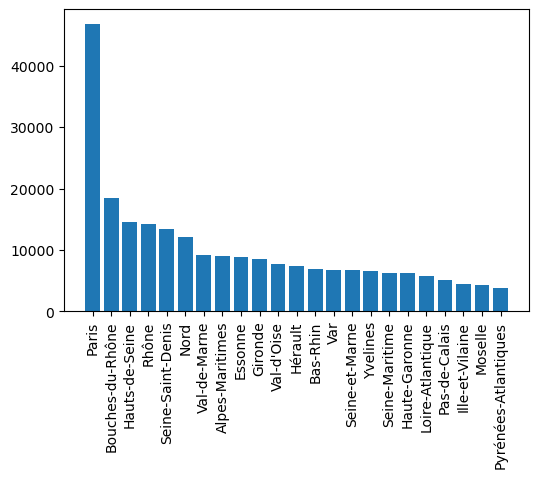

In [47]:
dep_count_geo.sort_values(by="tweet_count", ascending=False, inplace=True)

fig, ax = plt.subplots(1,1,dpi=100)
ax = plt.bar(dep_count_geo['nom'], dep_count_geo['tweet_count'])
plt.xticks(rotation='vertical')
fig.savefig('tweet_count_department', bbox_inches='tight')
plt.show()

## Build Corpus

In [48]:
# choose the content to analyze
lglda_material = "hashtags"

In [49]:
# build docs in format doc: [dep_code, list of tweet content material]
df_material = df[[len(mat)>0 for mat in df[lglda_material]]]
docs = [list(loc_tweet) for loc_tweet in zip(df.dep_code.values, df_material[lglda_material].values)]

# build dict
if FREQ_HIGH_THRES <= 1:
    # high_thres = FREQ_HIGH_THRES*len(df_material)
    high_thres = FREQ_HIGH_THRES
else:
    high_thres = FREQ_HIGH_THRES/len(df_material)
if FREQ_THRES < 1:
    low_thres = FREQ_THRES*len(df_material)
else:
    low_thres = FREQ_THRES

# all_material = list(itertools.chain(*df_material[lglda_material].values))
# word_freq = (Counter(all_material)).most_common()
# wordDict = [w[0] for w in word_freq if (w[1]>low_thres and w[1]<high_thres)]

# using gensim corpora to filter the words

dictionary = corpora.Dictionary(df_material['hashtags'])
dictionary.filter_extremes(no_below=FREQ_THRES, no_above=FREQ_HIGH_THRES)
corpus = [dictionary.doc2bow(tweet) for tweet in df_material['hashtags']]
wordDict = list(dictionary.token2id.keys())


_location_dict, _tweet_count, _word_count = {}, 0, 0

for _, row in tqdm(df_material.iterrows()):
    _id = row.dep_code
    _words = []
    _cont = row.text_clean # not completely sure what it is used for ?
    for _word in row[lglda_material]:
        if _word in wordDict:
            _words.append(_word)
    if len(_words) >=1:
        _tweet_count+=1
        _word_count+=len(_words)
        _location_dict[_id2name[_id]] = _location_dict.get(_id2name[_id],[]) + \
                                        [{'_words':_words,'_len':len(_words),'_cont':_cont}]

print("***  ***  ***  dataset statistics  ***  ***  ***")
print("tweet count:", _tweet_count)
print("location count:", len(_location_dict))
print("average word per tweet:", 1.*_word_count/_tweet_count)
    
    
run_tfidf()

25405it [00:02, 11409.78it/s]


***  ***  ***  dataset statistics  ***  ***  ***
tweet count: 11700
location count: 23
average word per tweet: 1.2541880341880343


In [17]:
n_it_test = 180
perplexities, topic_entropies, location_entropies, topic_KL_divs, coherences = run_lda_assess('LDALocalGlobalSampler'
                                                                   , num_iteration=n_it_test
                                                                   , save_step=20
                                                                   , num_topics=20
                                                                   , local_radio=0.6
                                                                   , alpha=0.5
                                                                   , beta=0.5
                                                                   , gamma=0.5
                                                                   , r_seed = 0
                                                                   , print_steps = False
                                                                   , write_results = False
                                                                   , corpus = corpus
                                                                   , dictionary = dictionary
                                                                  )



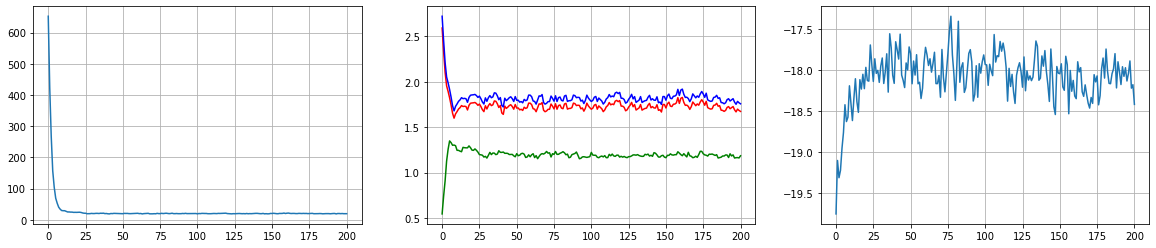

In [18]:
fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot (131)
ax2 = fig.add_subplot (132)
ax3 = fig.add_subplot (133)
ax1.plot(range(n_it_test), perplexities)
ax1.grid()
# ax2.plot(range(n_it_test), topic_entropies, marker="o", c='red', linewidth=0.5, markersize=6 )
# ax2.plot(range(n_it_test), location_entropies, marker="s", c='blue', linewidth=0.5, markersize=6 )
# ax2.plot(range(n_it_test), topic_KL_divs, marker="^", c='green', linewidth=0.5, markersize=6)
ax2.plot(range(n_it_test), topic_entropies,c='red')
ax2.plot(range(n_it_test), location_entropies, c='blue')
ax2.plot(range(n_it_test), topic_KL_divs, c='green')
ax2.grid()
ax3.plot(range(n_it_test), coherences)
ax3.grid()

np.arange(50, N_IT_MAX-1, 1, dtype=int)## Optimize hyperparameters

In [19]:
N_IT_MAX = 151
N_IT_MIN = 50

alpha_range = [0.5]
beta_range = [0.5]
gamma_range = [0.5]
n_topics_range = np.arange(3, 50, 2, dtype=int)
loc_ratio_range = [0.2, 0.6, 1.0, 10.0]
iteration_range=np.arange(N_IT_MIN, N_IT_MAX, 1, dtype=int)

print("nb tests = ", len(alpha_range)*len(beta_range)*len(gamma_range)*len(n_topics_range)*len(loc_ratio_range))

nb tests =  96


In [20]:
LGLDA_PARAMS = ["N_topics", "loc_ratio", "alpha", "beta", "gamma"]
LGLDA_best_scores = ["iterations", "perplexity", "topic_entropy", "location_entropy", "topic_KL", "coherence"]

assess_lglda = pd.DataFrame(columns=LGLDA_PARAMS+LGLDA_best_scores)

assess_lglda

,N_topics,loc_ratio,alpha,beta,gamma,iterations,perplexity,topic_entropy,location_entropy,topic_KL,coherence


In [21]:
# numpy array for saving the data
assessment_array = np.zeros((len(n_topics_range),len(loc_ratio_range), 
                             len(alpha_range),len(beta_range), len(gamma_range), 5, len(iteration_range)))
assessment_array.shape

(24, 4, 1, 1, 1, 5, 101)

In [22]:
for i, n_topics in tqdm(enumerate(n_topics_range)):
    for j, loc_ratio in enumerate(loc_ratio_range):
        for k, alpha in enumerate(alpha_range):
            for l, beta in enumerate(beta_range):
                for m, gamma in enumerate(gamma_range):
                    perplexities, topic_entropies, location_entropies, topic_KL_divs, coherences = \
                    run_lda_assess('LDALocalGlobalSampler'
                                  , num_iteration=N_IT_MAX
                                  , save_step=20
                                  , num_topics=n_topics
                                  , local_radio=loc_ratio
                                  , alpha=alpha
                                  , beta=beta
                                  , gamma=gamma
                                  , r_seed = 0
                                  , print_steps = False
                                  , write_results = False
                                  , corpus = corpus
                                  , dictionary = dictionary
                                 )
                    assessment_array[i, j, k, l, m, 0 ] = perplexities[N_IT_MIN:]
                    assessment_array[i, j, k, l, m, 1 ] = topic_entropies[N_IT_MIN:]
                    assessment_array[i, j, k, l, m, 2 ] = location_entropies[N_IT_MIN:]
                    assessment_array[i, j, k, l, m, 3 ] = topic_KL_divs[N_IT_MIN:]
                    assessment_array[i, j, k, l, m, 4 ] = coherences[N_IT_MIN:]
                    # optimize on topic KL divergence
                    best_it = [np.argmin(perplexities)
                               , np.argmin(topic_entropies)
                               , np.argmin(location_entropies)
                               , np.argmax(topic_KL_divs)
                               , np.argmax(coherences)
                              ]
                    best_it_KL = best_it[-2]
                    
                    df_curr = pd.DataFrame([[n_topics
                                             , loc_ratio
                                             , alpha
                                             , beta
                                             , gamma
                                             , best_it
                                             , perplexities[-1]
                                             , topic_entropies[-1]
                                             , location_entropies[-1]
                                             , topic_KL_divs[-1]
                                             , coherences[-1]
                                            ]]
                                           , columns=LGLDA_PARAMS+LGLDA_best_scores
                                          )
                    assess_lglda = assess_lglda.append(df_curr, ignore_index=True)            

24it [1:17:55, 194.80s/it]


In [23]:
assess_lglda

,N_topics,loc_ratio,alpha,beta,gamma,iterations,perplexity,topic_entropy,location_entropy,topic_KL,coherence
0,3,0.2,0.5,0.5,0.5,"[111, 63, 63, 111, 118]",26.202072,0.364905,2.554335,3.250880,-15.935234
1,3,0.6,0.5,0.5,0.5,"[53, 55, 55, 111, 86]",25.931643,0.208769,1.461382,3.329558,-15.853450
2,3,1.0,0.5,0.5,0.5,"[72, 121, 121, 33, 127]",27.108849,0.274501,1.921504,3.104621,-16.640501
3,3,10.0,0.5,0.5,0.5,"[17, 57, 57, 86, 9]",26.884853,0.184273,1.289914,3.110259,-17.243375
4,5,0.2,0.5,0.5,0.5,"[118, 118, 118, 33, 113]",22.653359,0.868599,3.648115,2.725315,-17.272537
...,...,...,...,...,...,...,...,...,...,...,...
91,47,10.0,0.5,0.5,0.5,"[124, 94, 94, 3, 144]",51.550636,2.008565,0.897444,0.585867,-19.406881
92,49,0.2,0.5,0.5,0.5,"[147, 147, 147, 2, 2]",63.839148,3.607405,1.546031,0.211311,-20.554115
93,49,0.6,0.5,0.5,0.5,"[113, 40, 40, 3, 130]",30.366701,2.820043,1.208590,0.520600,-19.240767
94,49,1.0,0.5,0.5,0.5,"[52, 88, 88, 3, 134]",31.753655,2.673310,1.145704,0.587333,-19.512813


In [24]:
assess_lglda.to_csv("assessment_array_hashtag_lamda_ntopic-3-50.csv", index=False)

In [25]:
np.save("assessment_array_hashtag_lamda_ntopic-3-50", assessment_array)

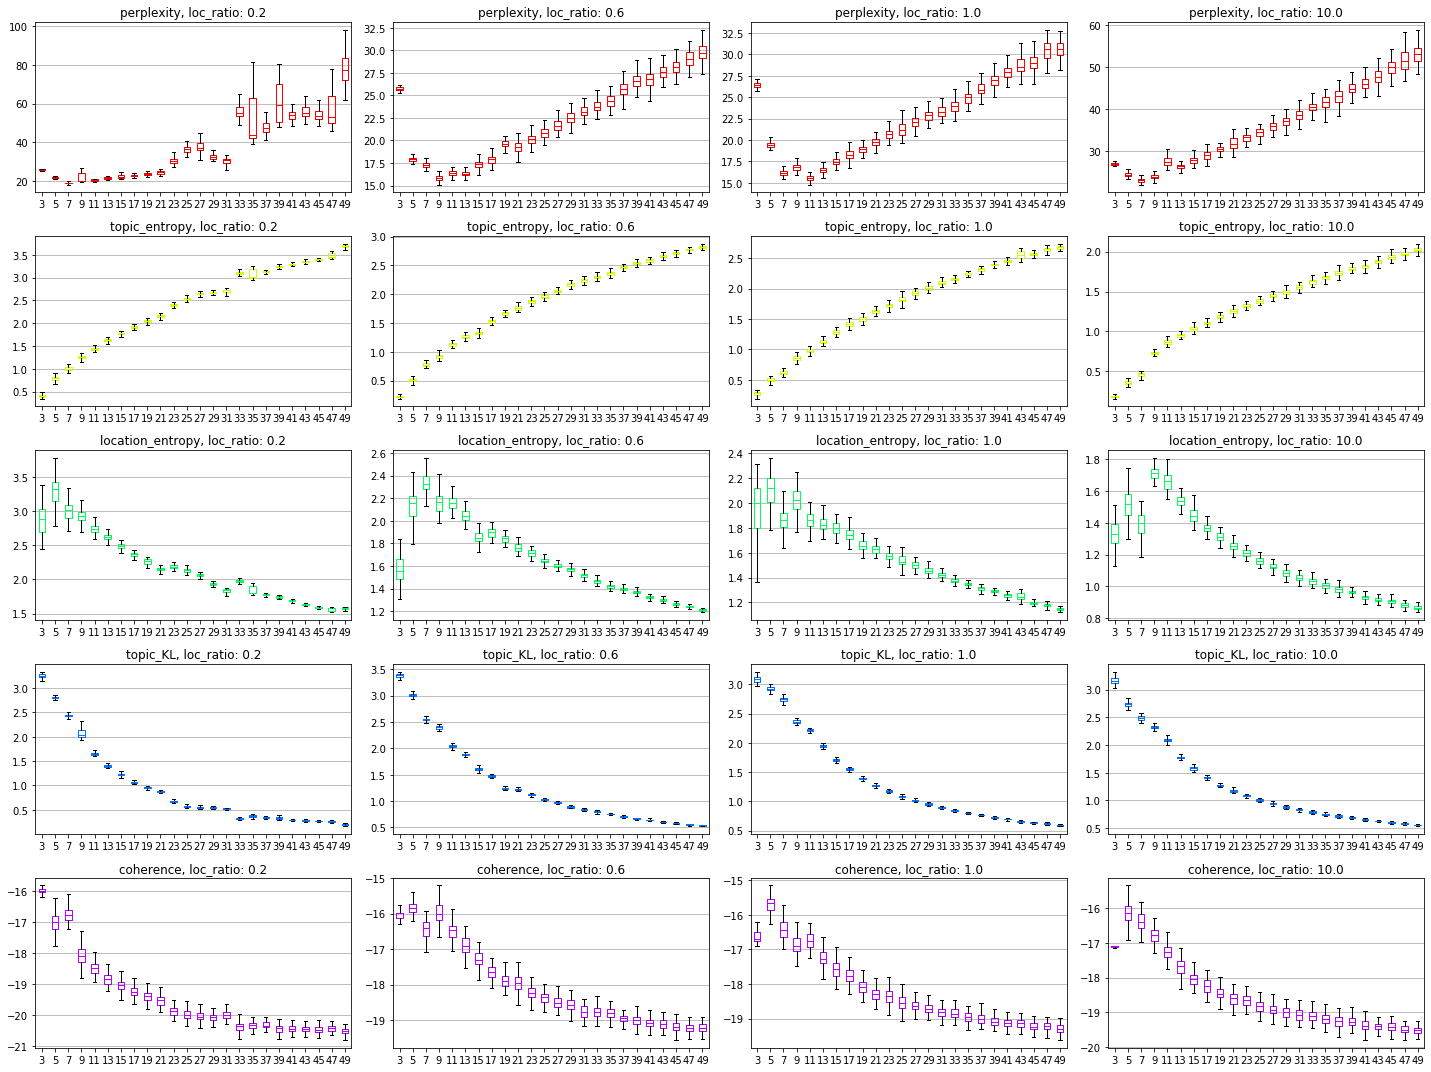

In [26]:
assessment_array= np.load("assessment_array_hashtag_lamda_ntopic-3-50.npy")

# plot with 4 lambda
scores = ["perplexity", "topic_entropy", "location_entropy", "topic_KL", "coherence"]

data = np.squeeze(assessment_array)

fig = plt.figure(figsize=(20,15))
cmap = cm.get_cmap('hsv')
for i, loc_ratio in enumerate(loc_ratio_range):
    for j, score in enumerate(scores):
        val = data[:,i,j,:]
        val = np.moveaxis(val, 0, 1)
        ax = fig.add_subplot(len(scores), len(loc_ratio_range), (j*len(loc_ratio_range))+i+1)
        ax.set_title(f"{score}, loc_ratio: {loc_ratio}")
        c = cmap(1.0/(len(scores))*j)
        ax.boxplot(val
            , boxprops=dict(color=c)
            , medianprops=dict(color=c, linewidth=1)
            , showfliers=False
            , labels=n_topics_range)
        ax.grid(axis='y')
fig.tight_layout()
fig.savefig("assessment_array_hashtag_lamda_ntopic-3-50")

In [27]:
assess_lglda

,N_topics,loc_ratio,alpha,beta,gamma,iterations,perplexity,topic_entropy,location_entropy,topic_KL,coherence
0,3,0.2,0.5,0.5,0.5,"[111, 63, 63, 111, 118]",26.202072,0.364905,2.554335,3.250880,-15.935234
1,3,0.6,0.5,0.5,0.5,"[53, 55, 55, 111, 86]",25.931643,0.208769,1.461382,3.329558,-15.853450
2,3,1.0,0.5,0.5,0.5,"[72, 121, 121, 33, 127]",27.108849,0.274501,1.921504,3.104621,-16.640501
3,3,10.0,0.5,0.5,0.5,"[17, 57, 57, 86, 9]",26.884853,0.184273,1.289914,3.110259,-17.243375
4,5,0.2,0.5,0.5,0.5,"[118, 118, 118, 33, 113]",22.653359,0.868599,3.648115,2.725315,-17.272537
...,...,...,...,...,...,...,...,...,...,...,...
91,47,10.0,0.5,0.5,0.5,"[124, 94, 94, 3, 144]",51.550636,2.008565,0.897444,0.585867,-19.406881
92,49,0.2,0.5,0.5,0.5,"[147, 147, 147, 2, 2]",63.839148,3.607405,1.546031,0.211311,-20.554115
93,49,0.6,0.5,0.5,0.5,"[113, 40, 40, 3, 130]",30.366701,2.820043,1.208590,0.520600,-19.240767
94,49,1.0,0.5,0.5,0.5,"[52, 88, 88, 3, 134]",31.753655,2.673310,1.145704,0.587333,-19.512813


In [50]:
N_IT_MAX = 151
N_IT_MIN = 50

alpha_range = [0.5]
beta_range = [0.5]
gamma_range = [0.5]
n_topics_range = np.arange(2, 25, 1, dtype=int)
loc_ratio_range = [0.6, 1.0]
iteration_range=np.arange(N_IT_MIN, N_IT_MAX, 1, dtype=int)

print("nb tests = ", len(alpha_range)*len(beta_range)*len(gamma_range)*len(n_topics_range)*len(loc_ratio_range))

nb tests =  46


In [51]:
LGLDA_PARAMS = ["N_topics", "loc_ratio", "alpha", "beta", "gamma"]
LGLDA_best_scores = ["iterations", "perplexity", "topic_entropy", "location_entropy", "topic_KL", "coherence"]

assess_lglda = pd.DataFrame(columns=LGLDA_PARAMS+LGLDA_best_scores)

assess_lglda

,N_topics,loc_ratio,alpha,beta,gamma,iterations,perplexity,topic_entropy,location_entropy,topic_KL,coherence


In [52]:
# numpy array for saving the data
assessment_array = np.zeros((len(n_topics_range),len(loc_ratio_range), 
                             len(alpha_range),len(beta_range), len(gamma_range), 5, len(iteration_range)))
assessment_array.shape

(23, 2, 1, 1, 1, 5, 101)

In [53]:
for i, n_topics in tqdm(enumerate(n_topics_range)):
    for j, loc_ratio in enumerate(loc_ratio_range):
        for k, alpha in enumerate(alpha_range):
            for l, beta in enumerate(beta_range):
                for m, gamma in enumerate(gamma_range):
                    perplexities, topic_entropies, location_entropies, topic_KL_divs, coherences = \
                    run_lda_assess('LDALocalGlobalSampler'
                                  , num_iteration=N_IT_MAX
                                  , save_step=20
                                  , num_topics=n_topics
                                  , local_radio=loc_ratio
                                  , alpha=alpha
                                  , beta=beta
                                  , gamma=gamma
                                  , r_seed = 0
                                  , print_steps = False
                                  , write_results = False
                                  , corpus = corpus
                                  , dictionary = dictionary
                                 )
                    assessment_array[i, j, k, l, m, 0 ] = perplexities[N_IT_MIN:]
                    assessment_array[i, j, k, l, m, 1 ] = topic_entropies[N_IT_MIN:]
                    assessment_array[i, j, k, l, m, 2 ] = location_entropies[N_IT_MIN:]
                    assessment_array[i, j, k, l, m, 3 ] = topic_KL_divs[N_IT_MIN:]
                    assessment_array[i, j, k, l, m, 4 ] = coherences[N_IT_MIN:]
                    # optimize on topic KL divergence
                    best_it = [np.argmin(perplexities)
                               , np.argmin(topic_entropies)
                               , np.argmin(location_entropies)
                               , np.argmax(topic_KL_divs)
                               , np.argmax(coherences)
                              ]
                    best_it_KL = best_it[-2]
                    
                    df_curr = pd.DataFrame([[n_topics
                                             , loc_ratio
                                             , alpha
                                             , beta
                                             , gamma
                                             , best_it
                                             , perplexities[-1]
                                             , topic_entropies[-1]
                                             , location_entropies[-1]
                                             , topic_KL_divs[-1]
                                             , coherences[-1]
                                            ]]
                                           , columns=LGLDA_PARAMS+LGLDA_best_scores
                                          )
                    assess_lglda = assess_lglda.append(df_curr, ignore_index=True)            

0it [00:00, ?it/s]

perplexity: 29.638011840295604


1it [00:13, 13.28s/it]

perplexity: 29.004462336361392
perplexity: 22.35843919549821


2it [00:28, 13.78s/it]

perplexity: 25.77942710752995
perplexity: 22.14343383415751


3it [00:43, 14.27s/it]

perplexity: 18.799288286524423
perplexity: 18.14279512505984


4it [01:00, 15.11s/it]

perplexity: 18.680878417288486
perplexity: 16.506624327883163


5it [01:19, 16.15s/it]

perplexity: 17.36014519073497
perplexity: 15.222601095820213


6it [01:39, 17.35s/it]

perplexity: 15.756761385313569
perplexity: 15.378356593805735


7it [02:01, 18.62s/it]

perplexity: 15.594278675127526
perplexity: 14.69464141004016


8it [02:24, 20.04s/it]

perplexity: 15.013864661377937
perplexity: 15.86530853496309


9it [02:49, 21.46s/it]

perplexity: 15.478885510207038
perplexity: 15.148948677507907


10it [03:15, 22.91s/it]

perplexity: 16.94941055516742
perplexity: 16.733638414485142


11it [03:43, 24.43s/it]

perplexity: 15.801652982881938
perplexity: 15.001981278574501


12it [04:14, 26.31s/it]

perplexity: 15.228650008441852
perplexity: 16.284930011081155


13it [04:45, 27.87s/it]

perplexity: 16.580141089749166
perplexity: 16.07223386954739


14it [05:19, 29.82s/it]

perplexity: 16.069326255334474
perplexity: 18.094673350757752


15it [05:55, 31.43s/it]

perplexity: 18.843511506165317
perplexity: 16.839637043684075


16it [06:31, 32.93s/it]

perplexity: 17.68700633997734
perplexity: 17.193849167919506


17it [07:08, 34.15s/it]

perplexity: 17.7458939436189
perplexity: 18.293920940237378


18it [07:48, 35.98s/it]

perplexity: 18.048911246445986
perplexity: 19.153900966867017


19it [08:31, 37.88s/it]

perplexity: 18.66714941201295
perplexity: 18.243825601823595


20it [09:14, 39.66s/it]

perplexity: 19.3583078398006
perplexity: 20.09175930359426


21it [09:58, 40.83s/it]

perplexity: 19.428637457704987
perplexity: 19.645874281096194


22it [10:45, 42.81s/it]

perplexity: 20.54944334583792
perplexity: 20.02486908308311


23it [11:34, 30.21s/it]

perplexity: 20.874074875961075


In [55]:
assess_lglda.to_csv("assessment_array_hashtag_lamda_ntopic-2-25_0.6_1.0.csv", index=False)

In [56]:
np.save("assessment_array_hashtag_lamda_ntopic-2-25_0.6_1.0", assessment_array)

In [57]:
assessment_array = np.load("assessment_array_hashtag_lamda_ntopic-2-25_0.6_1.0.npy")
data = np.squeeze(assessment_array)
data.shape

(23, 2, 5, 101)

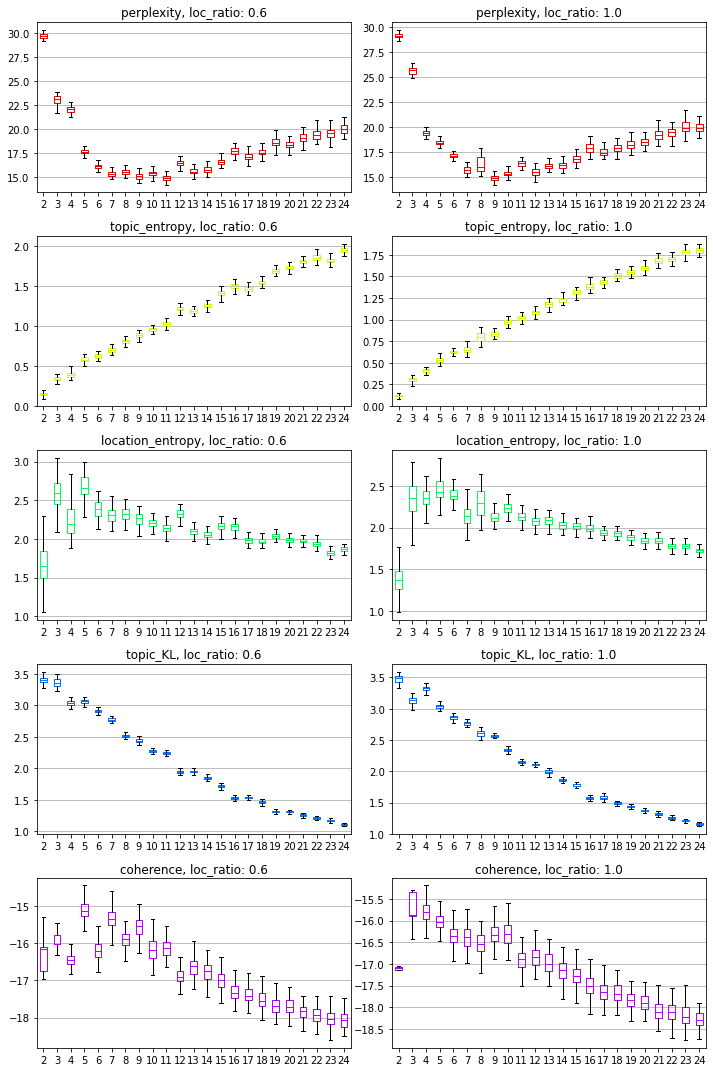

In [58]:
# plot with 4 lambda
scores = ["perplexity", "topic_entropy", "location_entropy", "topic_KL", "coherence"]

data = np.squeeze(assessment_array)

fig = plt.figure(figsize=(10,15))
cmap = cm.get_cmap('hsv')
for i, loc_ratio in enumerate(loc_ratio_range):
    for j, score in enumerate(scores):
        val = data[:,i,j,:]
        val = np.moveaxis(val, 0, 1)
        ax = fig.add_subplot(len(scores), len(loc_ratio_range), (j*len(loc_ratio_range))+i+1)
        ax.set_title(f"{score}, loc_ratio: {loc_ratio}")
        c = cmap(1.0/(len(scores))*j)
        ax.boxplot(val
            , boxprops=dict(color=c)
            , medianprops=dict(color=c, linewidth=1)
            , showfliers=False
            , labels=n_topics_range)
        ax.grid(axis='y')
fig.tight_layout()
fig.savefig("assessment_array_hashtag_lamda_ntopic-2-25_6e-1_1e0")

In [24]:
n_it_test = 180
perplexities, topic_entropies, location_entropies, topic_KL_divs, coherences = run_lda_assess('LDALocalGlobalSampler'
                                                                   , num_iteration=n_it_test
                                                                   , save_step=5
                                                                   , num_topics=12
                                                                   , local_radio=1.0
                                                                   , alpha=0.5
                                                                   , beta=0.5
                                                                   , gamma=0.5
                                                                   , r_seed = 0
                                                                   , print_steps = True
                                                                   , write_results = True
                                                                   , corpus = corpus
                                                                   , dictionary = dictionary
                                                                  )

iteration: 0
perplexity: 368.08961447059255
topic entropy: 2.096229003500359
location entropy: 3.6684007561256267
topic KL-divergence: 0.634112906718153
coherence: -19.05208228815651
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
perplexity: 44.12584692517256
topic entropy: 1.18594170308719
location entropy: 2.0753979804025824
topic KL-divergence: 1.963822463824331
coherence: -17.543889591368206
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
perplexity: 24.363642022939885
topic entropy: 1.0814843751462468
location entropy: 1.892597656505932
topic KL-divergence: 2.0787519083645387
coherence: -17.1032932526041
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
perplexity: 16.870005679419418
topic entropy: 1.0577537748272643
location entropy: 1.8510691059477127
topic KL-divergence: 2.0502754844020115
coherence: -17.157021658732827
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
perplexity: 16.260914944513942
top

In [21]:
np.argmax(topic_KL_divs)

179